Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Figure 12.23 and Section 12.9

Diagnosis of Alzheimer's disease using features representing volumes of two brain regions (hippocampus and entorhinal cortes) extracted from magnetic resonance imaging scans.\
Topics and relevant videos: [Classification](https://www.youtube.com/watch?v=pfIPwD2mWbo), [logistic regression](https://www.youtube.com/watch?v=YjjwrW6jzHc), [evaluation of classification models, calibration](https://www.youtube.com/watch?v=wYflzBlGigM)

Author: Carlos Fernandez-Granda\
Data source: https://github.com/NYUMedML/CNN_design_for_AD/tree/master/datasets

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import norm
import matplotlib 
# matplotlib.rcParams['text.usetex'] = True
from sklearn import metrics

font_size = 15
font_size_legend = 15
font_size_ticks = 15

# train_set = pd.read_csv ("../data/alzheimers/ADNI_train_volumes.tsv", sep = ',')
# test_set = pd.read_csv ("../data/alzheimers/ADNI_val_volumes.tsv", sep = ',')
# nacc_set = pd.read_csv ("../data/alzheimers/NACC_volumes.tsv", sep = ',')

# Raw GitHub URLs
url_train = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/alzheimers/ADNI_train_volumes.tsv"
url_test = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/alzheimers/ADNI_val_volumes.tsv"
url_nacc = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/alzheimers/NACC_volumes.tsv"

# Load and clean data
train_set = pd.read_csv(url_train, sep=',')
train_set.dropna(subset=['Left-Hippocampus'], inplace=True)

# This test set can be used for in-distribution evaluation; here we only do OOD evaluation on the NACC cohort
test_set = pd.read_csv(url_test, sep=',')
test_set.dropna(subset=['Left-Hippocampus'], inplace=True)

nacc_set = pd.read_csv(url_nacc, sep=',')
nacc_set.dropna(subset=['Left-Hippocampus'], inplace=True)

labels_train = train_set["diagnosis"]
labels_nacc = nacc_set["diagnosis"]
print("Training examples: " + str(len(labels_train)))
print("Fraction of Alzheimer's disease (AD): " + str(np.round(pd.Series(labels_train).value_counts()["AD"] / len(labels_train),3)))
print("NACC test examples: " + str(len(labels_nacc)))
print("Fraction of AD: " + str(np.round(pd.Series(labels_nacc).value_counts()["AD"] / len(labels_nacc),3)))

Training examples: 1936
Fraction of Alzheimer's disease (AD): 0.271
NACC test examples: 2045
Fraction of AD: 0.216


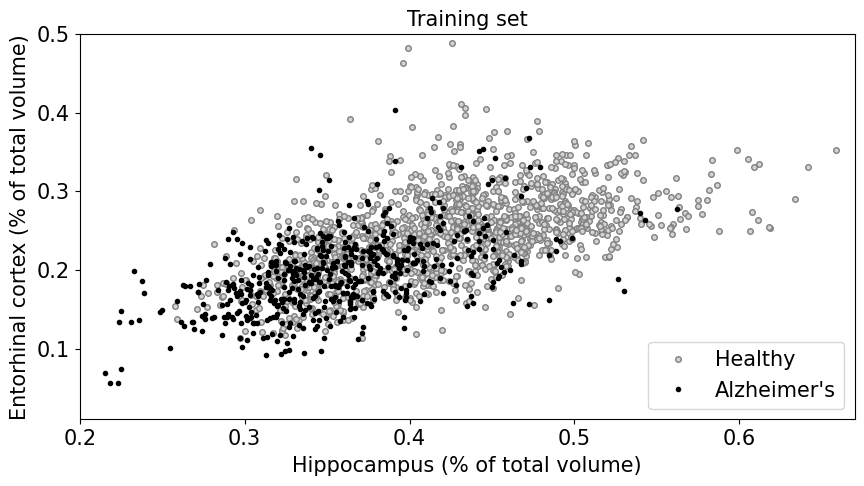

In [8]:
# The two features are the volume of the hippocampus and of the entorhinal cortex, normalized by the total brain volume 
total_volume_train = train_set["EstimatedTotalIntraCranialVol"]
hippocampus_train = (train_set["Left-Hippocampus"] + train_set["Right-Hippocampus"]) 
entorhinal_train = (train_set["lh_entorhinal_volume"] + train_set["rh_entorhinal_volume"]) 
hippocampus_norm_train = hippocampus_train/total_volume_train * 100
entorhinal_norm_train = entorhinal_train/total_volume_train * 100

hippocampus_norm_notAD_train = np.array(hippocampus_norm_train[labels_train.isin(["CN","MCI"])])
hippocampus_norm_AD_train = np.array(hippocampus_norm_train[labels_train=="AD"])
entorhinal_norm_notAD_train = np.array(entorhinal_norm_train[labels_train.isin(["CN","MCI"])])
entorhinal_norm_AD_train = np.array(entorhinal_norm_train[labels_train=="AD"])

min_hippocampus = 0.2
max_hippocampus = 0.67
min_entorhinal = 0.01
max_entorhinal = 0.5

markersize = 4
plt.figure(figsize=(10,5))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, 'o',markersize=markersize,markerfacecolor='lightgray',markeredgecolor="gray",
         label='Healthy')
plt.plot(hippocampus_norm_AD_train,entorhinal_norm_AD_train, 'o',markersize=markersize-1,markerfacecolor='black',markeredgecolor="black",
         label='Alzheimer\'s')
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlabel("Hippocampus (% of total volume)",fontsize=font_size,labelpad=5)
plt.ylabel('Entorhinal cortex (% of total volume)',fontsize=font_size,labelpad=5)
plt.legend(fontsize=font_size,loc="lower right")
plt.title("Training set",fontsize=font_size);

In [9]:
hippo_aux = np.concatenate((hippocampus_norm_AD_train,hippocampus_norm_notAD_train))
ento_aux = np.concatenate((entorhinal_norm_AD_train,entorhinal_norm_notAD_train))
X = np.array([hippo_aux,ento_aux])
n = len(hippo_aux)
y = np.zeros(n)
aux_ones = len(hippocampus_norm_AD_train)
y[:aux_ones] = 1
logistic_model = LogisticRegression(solver='lbfgs',penalty=None).fit(X.T, y)
print("Intercept",np.round(logistic_model.intercept_,2))
print("Linear coefficients: ",np.round(logistic_model.coef_,2))

Intercept [5.98]
Linear coefficients:  [[-12.32 -10.01]]


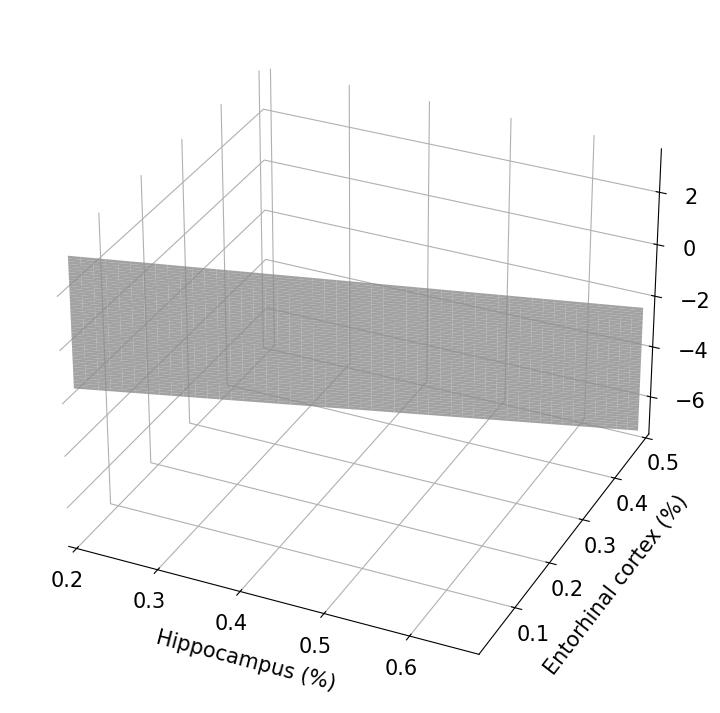

In [10]:
# Logits
hippocampus_aux = np.linspace(min_hippocampus, max_hippocampus, 50)  
entorhinal_aux = np.linspace(min_entorhinal, max_entorhinal, 50) 

hippocampus_grid, entorhinal_grid = np.meshgrid(hippocampus_aux, entorhinal_aux)

logit = (hippocampus_grid * logistic_model.coef_[0][0] + entorhinal_grid * logistic_model.coef_[0][1] 
         + logistic_model.intercept_[0] )

fig = plt.figure(figsize = (9,9)) 
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.plot_surface(hippocampus_aux, entorhinal_aux,logit, color='lightgray', alpha=0.8,
               rstride=1,cstride=1)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
for t in ax.zaxis.get_major_ticks(): t.label1.set_fontsize(font_size_ticks)
for t in ax.zaxis.get_major_ticks(): t.label1.set_horizontalalignment("left")
plt.xlabel("Hippocampus (%)",fontsize=font_size,labelpad=10)
plt.ylabel('Entorhinal cortex (%)',fontsize=font_size,labelpad=10)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
ax.view_init(elev=30, azim=-65)
ax.dist = 10.5;

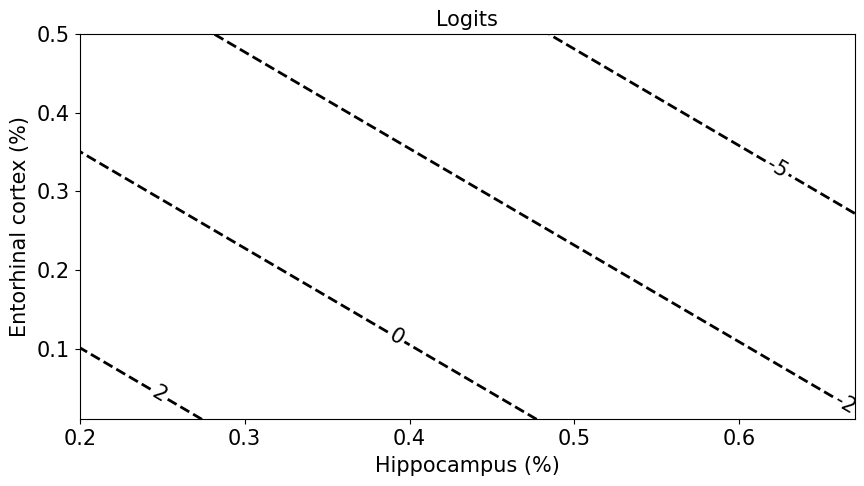

In [11]:
plt.figure(figsize=(10,5))
plt.ylim([min_entorhinal,max_entorhinal])
plt.xlim([min_hippocampus,max_hippocampus])
CS = plt.contour(hippocampus_aux, entorhinal_aux,logit, levels=4,colors='black',linewidths=2,linestyles="dashed")
plt.clabel(CS, CS.levels, inline=True, fontsize=font_size,inline_spacing=3, rightside_up=True,fmt='%1.0f')#,manual=manual_locations)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel("Hippocampus (%)",fontsize=font_size,labelpad=5)
plt.ylabel('Entorhinal cortex (%)',fontsize=font_size,labelpad=5)
plt.title("Logits",fontsize=font_size);

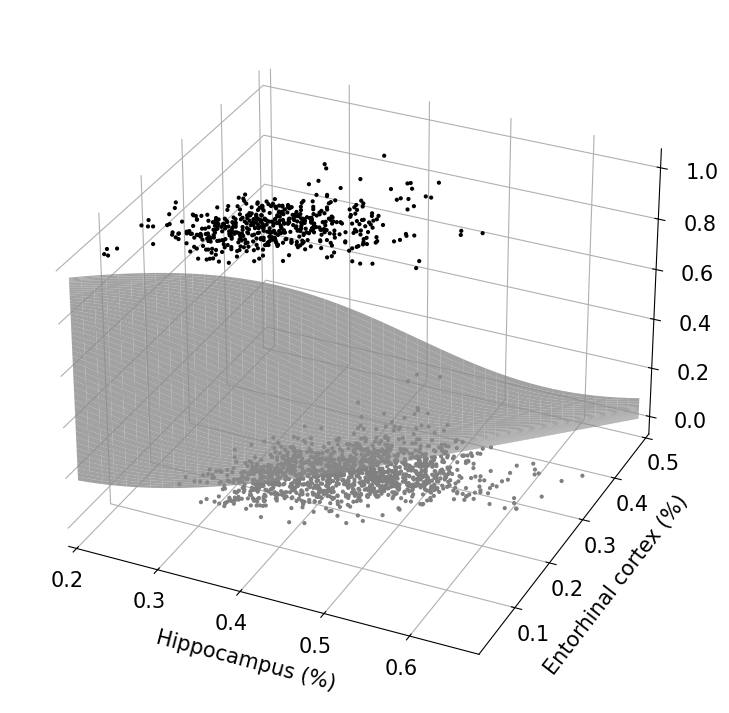

In [12]:
def logistic_function(a):
    return 1/(1+np.exp(-a))

probabilities = logistic_function(logit)

fig = plt.figure(figsize = (9,9)) 
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.plot_surface(hippocampus_aux, entorhinal_aux,probabilities, color='lightgray', alpha=0.8,
               rstride=1,cstride=1)
ax.scatter(hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, np.zeros(len(entorhinal_norm_notAD_train)),#markersize=markersize,
           'o',color='gray',alpha=1,s=markersize)
ax.scatter(hippocampus_norm_AD_train,entorhinal_norm_AD_train, np.ones(len(entorhinal_norm_AD_train)),#markersize=markersize,
           'o',color='black',alpha=1,s=markersize)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
for t in ax.zaxis.get_major_ticks(): t.label1.set_fontsize(font_size_ticks)
for t in ax.zaxis.get_major_ticks(): t.label1.set_horizontalalignment("left")
plt.xlabel("Hippocampus (%)",fontsize=font_size,labelpad=10)
plt.ylabel('Entorhinal cortex (%)',fontsize=font_size,labelpad=10)
ax.view_init(elev=30, azim=-65)
ax.dist = 10.5
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal]);

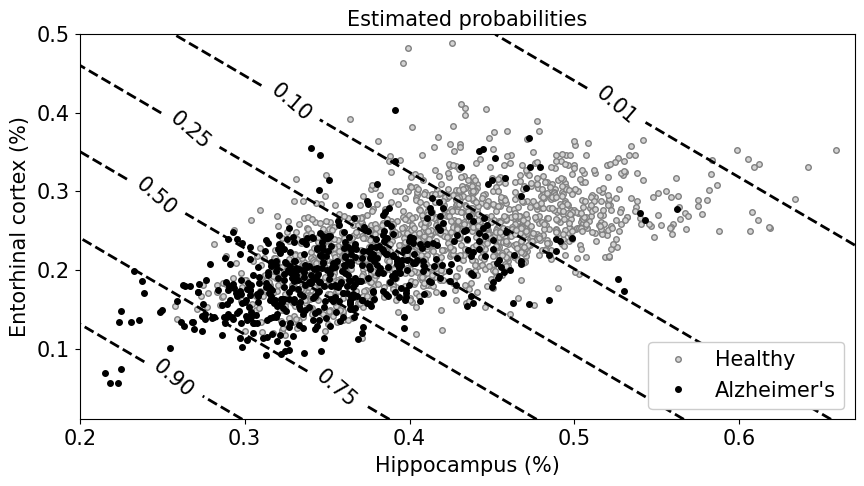

In [13]:
levels_p = [0.01,0.1,0.25,0.5,0.75,0.9]
plt.figure(figsize=(10,5))
plt.plot(hippocampus_norm_notAD_train,entorhinal_norm_notAD_train, 'o',markersize=markersize,markerfacecolor='lightgray',
         markeredgecolor="gray",label='Healthy')
plt.plot(hippocampus_norm_AD_train,entorhinal_norm_AD_train, 'o',markersize=markersize,markerfacecolor='black',
         markeredgecolor="black",label='Alzheimer\'s')
CS = plt.contour(hippocampus_aux, entorhinal_aux,probabilities, levels=levels_p,colors='black',linewidths=2,linestyles="dashed")
manual_locations = [(0.55, 0.45), (0.35, 0.45), (0.25, 0.35), (0.25, 0.3),(0.35, 0.04),(0.25, 0.05)]
plt.clabel(CS, CS.levels, inline=True, fontsize=font_size_ticks,inline_spacing=3, rightside_up=True,fmt='%1.2f'
          ,manual=manual_locations)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel("Hippocampus (%)",fontsize=font_size,labelpad=5)
plt.ylabel('Entorhinal cortex (%)',fontsize=font_size,labelpad=5)
plt.xlim([min_hippocampus,max_hippocampus])
plt.ylim([min_entorhinal,max_entorhinal])
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.title("Estimated probabilities",fontsize=font_size);

In [14]:
def conditional_p_AD(hippocampus,entorhinal):
    X_aux = np.array([[hippocampus,entorhinal]])
    return logistic_model.predict_proba(X_aux)[0][1]
    
def evaluate_log_reg(hippocampus_norm_AD,entorhinal_norm_AD,hippocampus_norm_notAD,entorhinal_norm_notAD,threshold):
    
    AD_predicted_as_AD = 0
    AD_predicted_as_notAD = 0
    notAD_predicted_as_notAD = 0
    notAD_predicted_as_AD = 0

    for ind in range(len(hippocampus_norm_AD)):
        if conditional_p_AD(hippocampus_norm_AD[ind],entorhinal_norm_AD[ind]) > threshold:
            AD_predicted_as_AD += 1
        else:
            AD_predicted_as_notAD += 1
    for ind in range(len(hippocampus_norm_notAD)):
        if conditional_p_AD(hippocampus_norm_notAD[ind],entorhinal_norm_notAD[ind]) > threshold:
            notAD_predicted_as_AD += 1
        else:
            notAD_predicted_as_notAD += 1
    error_rate = 1- (AD_predicted_as_AD + notAD_predicted_as_notAD)/(
        AD_predicted_as_AD + notAD_predicted_as_notAD + AD_predicted_as_notAD 
        + notAD_predicted_as_AD)
    return [error_rate, AD_predicted_as_AD, AD_predicted_as_notAD,notAD_predicted_as_notAD,notAD_predicted_as_AD]


[accuracy_train, AD_predicted_as_AD_train, AD_predicted_as_notAD_train,
 notAD_predicted_as_notAD_train,notAD_predicted_as_AD_train] = evaluate_log_reg(hippocampus_norm_AD_train,entorhinal_norm_AD_train,
                                                                           hippocampus_norm_notAD_train,entorhinal_norm_notAD_train,
                                                                           0.5)

print("Evaluation of logistic regression model on the training set")
print("AD predicted as AD: " + str(AD_predicted_as_AD_train))
print("AD predicted as not AD: " + str(AD_predicted_as_notAD_train))
print("not AD predicted as not AD: " + str(notAD_predicted_as_notAD_train))
print("not AD predicted as AD: " + str(notAD_predicted_as_AD_train))
print("Accuracy: " + str(np.round(accuracy_train,3)))

Evaluation of logistic regression model on the training set
AD predicted as AD: 187
AD predicted as not AD: 338
not AD predicted as not AD: 1277
not AD predicted as AD: 129
Accuracy: 0.242


In [15]:
total_volume_nacc = nacc_set["EstimatedTotalIntraCranialVol"]
hippocampus_nacc = (nacc_set["Left-Hippocampus"] + nacc_set["Right-Hippocampus"])
entorhinal_nacc = (nacc_set["lh_entorhinal_volume"] + nacc_set["rh_entorhinal_volume"])
hippocampus_norm_nacc = hippocampus_nacc/total_volume_nacc * 100
entorhinal_norm_nacc = entorhinal_nacc/total_volume_nacc * 100

hippocampus_norm_notAD_nacc = np.array(hippocampus_norm_nacc[labels_nacc.isin(["CN","MCI"])])
hippocampus_norm_AD_nacc = np.array(hippocampus_norm_nacc[labels_nacc=="AD"])
entorhinal_norm_notAD_nacc = np.array(entorhinal_norm_nacc[labels_nacc.isin(["CN","MCI"])])
entorhinal_norm_AD_nacc = np.array(entorhinal_norm_nacc[labels_nacc=="AD"])

hippo_aux_nacc = np.concatenate((hippocampus_norm_AD_nacc,hippocampus_norm_notAD_nacc))
ento_aux_nacc = np.concatenate((entorhinal_norm_AD_nacc,entorhinal_norm_notAD_nacc))
X_nacc = np.array([hippo_aux_nacc,ento_aux_nacc])
n_nacc = len(hippo_aux_nacc)
y_nacc = np.zeros(n_nacc)
n_AD_nacc = len(hippocampus_norm_AD_nacc)
y_nacc[:n_AD_nacc] = 1
estimated_probabilities_nacc = logistic_model.predict_proba(X_nacc.T)

In [16]:
print("Evaluation on test set")
thresh_vals = [0.05,0.2,0.5]
tpr_thresh = np.zeros(len(thresh_vals))
fpr_thresh = np.zeros(len(thresh_vals))

for ind,thresh in enumerate(thresh_vals):
    [error_rate_nacc, AD_predicted_as_AD_nacc, AD_predicted_as_notAD_nacc,
     notAD_predicted_as_notAD_nacc,notAD_predicted_as_AD_nacc] = evaluate_log_reg(hippocampus_norm_AD_nacc,entorhinal_norm_AD_nacc,
                                                                           hippocampus_norm_notAD_nacc,entorhinal_norm_notAD_nacc,
                                                                           thresh)

    print("Threshold",thresh)
    print("True positives: " + str(AD_predicted_as_AD_nacc))
    print("False negatives: " + str(AD_predicted_as_notAD_nacc))
    print("True negatives: " + str(notAD_predicted_as_notAD_nacc))
    print("False positives: " + str(notAD_predicted_as_AD_nacc))
    tpr_thresh[ind] = AD_predicted_as_AD_nacc/(AD_predicted_as_AD_nacc+AD_predicted_as_notAD_nacc)
    fpr_thresh[ind] = notAD_predicted_as_AD_nacc/(notAD_predicted_as_AD_nacc+notAD_predicted_as_notAD_nacc)
    print("True positive rate",round(tpr_thresh[ind],3))
    print("False positive rate",round(fpr_thresh[ind],3))
    print("Accuracy",round(1-error_rate_nacc,3))
    print("Specificity (true negative rate)",round(notAD_predicted_as_notAD_nacc/(notAD_predicted_as_notAD_nacc + notAD_predicted_as_AD_nacc)
                                                   ,3))
    print("Precision (positive predictive value)",round(AD_predicted_as_AD_nacc/(AD_predicted_as_AD_nacc+notAD_predicted_as_AD_nacc),3))
    


Evaluation on test set
Threshold 0.05
True positives: 410
False negatives: 32
True negatives: 788
False positives: 815
True positive rate 0.928
False positive rate 0.508
Accuracy 0.586
Specificity (true negative rate) 0.492
Precision (positive predictive value) 0.335
Threshold 0.2
True positives: 266
False negatives: 176
True negatives: 1400
False positives: 203
True positive rate 0.602
False positive rate 0.127
Accuracy 0.815
Specificity (true negative rate) 0.873
Precision (positive predictive value) 0.567
Threshold 0.5
True positives: 88
False negatives: 354
True negatives: 1579
False positives: 24
True positive rate 0.199
False positive rate 0.015
Accuracy 0.815
Specificity (true negative rate) 0.985
Precision (positive predictive value) 0.786


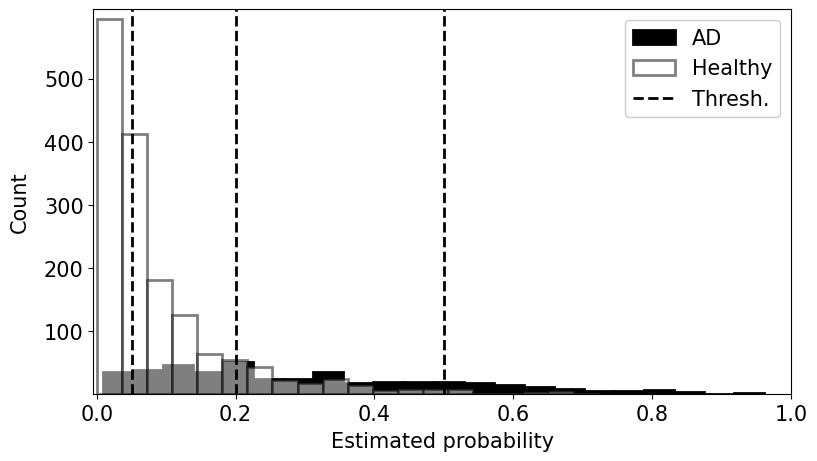

In [18]:
AD_estimated_probabilities = estimated_probabilities_nacc[:n_AD_nacc,1]
notAD_estimated_probabilities = estimated_probabilities_nacc[n_AD_nacc:,1]
n_bins = 22
ymax = 610
plt.figure(figsize=(9,5))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks([100,200,300,400,500],fontsize=font_size_ticks)
plt.ylim([0,ymax])
plt.xlim([-0.005,1])
#plt.xlim([assists_min_hist,assists_max])
plt.hist(AD_estimated_probabilities,bins=n_bins,
         color='black', edgecolor='black',
          linewidth=2,density=False,label='AD')
plt.hist(notAD_estimated_probabilities,bins=n_bins,
         color='white', edgecolor='black',alpha=0.5,
          linewidth=2,density=False,label='Healthy')
plt.vlines(thresh_vals[0],0,ymax,ls="--",lw=2,color='black',label="Thresh.")
plt.vlines(thresh_vals[1],0,ymax,ls="--",lw=2,color='black')
plt.vlines(thresh_vals[2],0,ymax,ls="--",lw=2,color='black')
plt.xlabel("Estimated probability",fontsize=font_size_ticks,labelpad=5)
plt.ylabel("Count",fontsize=font_size_ticks,labelpad=10)
plt.legend(fontsize=font_size_legend,framealpha=1);

AUC 0.848


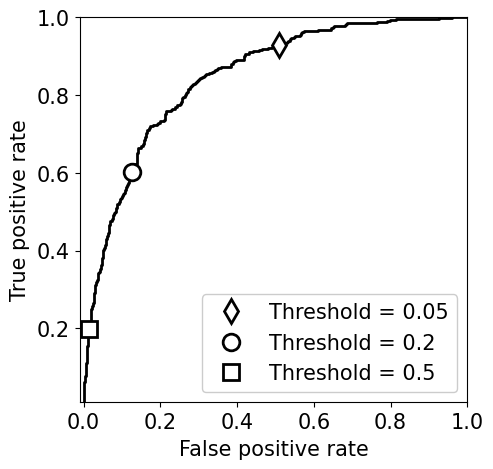

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_nacc, estimated_probabilities_nacc[:,1])
markers = ["d","o","s"]
markersize =12
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, color="black")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([-0.01,1])
plt.ylim([0.01,1])
plt.xlabel('False positive rate',fontsize=font_size_ticks,labelpad=5)
plt.ylabel('True positive rate',fontsize=font_size_ticks,labelpad=5)
for ind,thresh in enumerate(thresh_vals):
    plt.plot(fpr_thresh[ind],tpr_thresh[ind],markers[ind],markersize=markersize,markerfacecolor='white',
         markeredgecolor="black",markeredgewidth=2,label='Threshold = '+str(thresh))
plt.legend(fontsize=font_size_legend,framealpha=1,loc="lower right")

print('AUC',round(metrics.auc(fpr, tpr),3))

In [21]:
# Monte Carlo computation of the AUC, leveraging that it is equal to the concordance 
n_MC = int(1e5)
selected_positives = np.random.choice(AD_estimated_probabilities,n_MC)
selected_negatives = np.random.choice(notAD_estimated_probabilities,n_MC)
fraction = np.sum(selected_positives > selected_negatives)/n_MC
print("Monte Carlo AUC estimate",round(fraction,3))

Monte Carlo AUC estimate 0.848


In [22]:
step = 0.1
probability_thresholds = np.arange(0,1+step,step) 
n_intervals = len(probability_thresholds)-1
empirical_probability = np.zeros(n_intervals)
AD_counts = np.zeros(n_intervals)
notAD_counts = np.zeros(n_intervals)
for ind in range(1,len(probability_thresholds)):
    aux_inds = ((estimated_probabilities_nacc[:,1]<probability_thresholds[ind]) &
                (estimated_probabilities_nacc[:,1]>=probability_thresholds[ind-1]))
    empirical_probability[ind-1] = np.mean(y_nacc[aux_inds])
    AD_counts[ind-1] = np.sum(y_nacc[aux_inds])
    notAD_counts[ind-1] = len(y_nacc[aux_inds]) - AD_counts[ind-1]

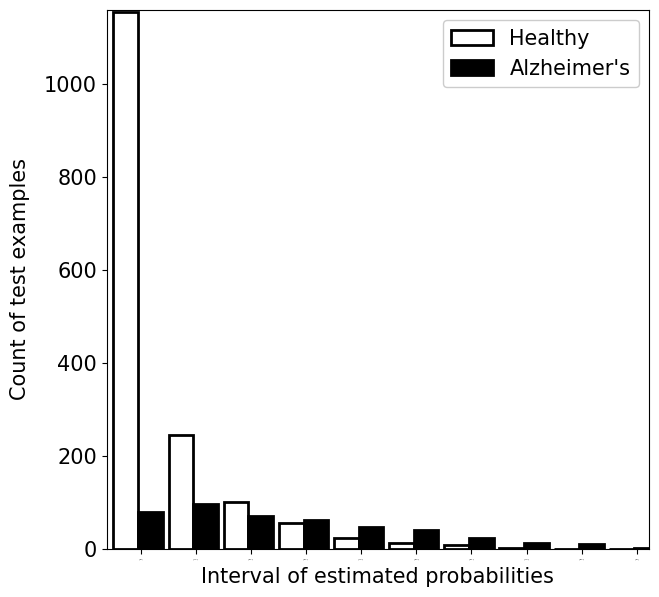

In [24]:
# Position of bars on x-axis
ind = np.arange(n_intervals)

# Figure size
plt.figure(figsize=(7,7))

# Width of a bar 
width = 0.45       

plt.xticks(fontsize=font_size_ticks-15) 
plt.yticks(fontsize=font_size_ticks)

# Plotting
plt.bar(ind, notAD_counts , width,color="white",edgecolor="black",linewidth=2, label='Healthy',log=False)
plt.bar(ind + width, AD_counts, width, color="black",edgecolor="black",linewidth=2,label='Alzheimer\'s',log=False)

plt.xlabel(r'Interval of estimated probabilities',fontsize=font_size_ticks,labelpad=5)
plt.ylabel('Count of test examples',fontsize=font_size_ticks,labelpad=10)

plt.ylim([0,1160])
plt.xlim([-0.35,9.5])
plt.xticks(ind + width / 2 + 0.05, ('[0,0.1)', '[0.1,0.2)','[0.2,0.3)',
                            '[0.3,0.4)', '[0.4,0.5)','[0.5,0.6)',
                            '[0.6,0.7)', '[0.7,0.8)','[0.8,0.9)',
                            '[0.9,1]'))
plt.legend(fontsize=font_size_legend,framealpha=1,loc='best');

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


Text(0.5, 1.0, 'Reliability diagram')

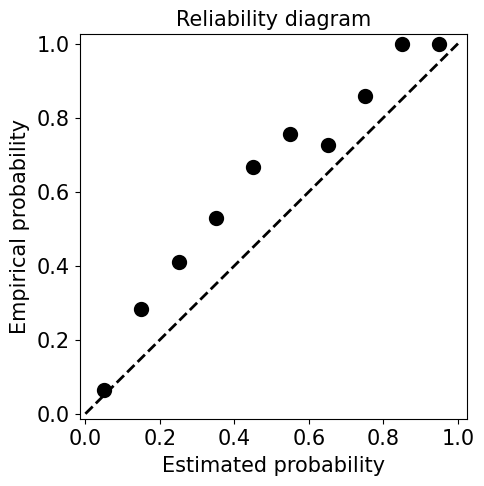

In [25]:
estimated_probability = np.arange(step/2,1,step)
print(estimated_probability)
plt.figure(figsize=(5,5))
plt.plot(estimated_probability, empirical_probability,'o',markersize=8, markerfacecolor='black',
         markeredgecolor="black",markeredgewidth=3)
plt.plot([0,1],[0,1], lw=2, color="black",ls='dashed')
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([-0.015,1.025])
plt.ylim([-0.015,1.025])
plt.xlabel('Estimated probability',fontsize=font_size_ticks,labelpad=5)
plt.ylabel('Empirical probability',fontsize=font_size_ticks,labelpad=5)
plt.title('Reliability diagram',fontsize=font_size)

In [26]:
brier_score = metrics.brier_score_loss(y_nacc, estimated_probabilities_nacc[:,1])
brier_score_sanity_check = np.mean((y_nacc - estimated_probabilities_nacc[:,1])**2)
print('Brier score:',round(brier_score,3))
print('Sanity check:',round(brier_score_sanity_check,3))
prob_cal = np.mean(y_nacc)*np.ones(len(y_nacc))
brier_score_cal = metrics.brier_score_loss(y_nacc, prob_cal)
print('Baseline with perfect calibration, Brier score:',round(brier_score_cal,3))
prob_disc = np.zeros(len(y_nacc))
prob_disc[y_nacc == 1] = 0.9
prob_disc[y_nacc == 0] = 0.8
brier_score_disc = metrics.brier_score_loss(y_nacc, prob_disc)
print('Baseline with perfect discrimination, Brier score:',round(brier_score_disc,3))


Brier score: 0.131
Sanity check: 0.131
Baseline with perfect calibration, Brier score: 0.169
Baseline with perfect discrimination, Brier score: 0.504
